In [46]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio, display

# audio example
samples, sr = librosa.load("audio_examples/voice.wav", sr=44100)

# 2 seconds
samples = samples[sr: sr * 3]

## **Shelving Filters**

### **First-Order Design**

First-order shelf filters can be constructed based on a **first-order allpass filter**, similar to those explored in IIR filter designs. The transfer function for a first-order shelf filter is given by:

$$
\large
H(z) = 1 + \frac{H_0}{2} [1 \pm A(z)]
\large
$$

- The **+** sign is used for **low-frequency shelving** (LF),
- The **−** sign is used for **high-frequency shelving** (HF).

The allpass filter $A(z) $ is defined as:

$$
\large
A(z) = \frac{z^{-1} + c_{b/c}}{1 + c_{b/c} \cdot z^{-1}}
\large
$$

<br>

with the following **difference equation**:


$$
\large
x_h(n) = x(n) - c_{b/c} \cdot x_h(n-1)
\large
$$

$$
\large
y_{ap}(n) = c_{b/c} \cdot x(n) + x_h(n-1)
\large
$$

$$
\large
y(n) = \frac{H_0}{2}[x(n) \pm y_{ap}(n)] + x(n)
\large
$$
<br>

Where $c_{b/c}$ is either the **boost** or **cut** and $H_0$, the gain. These parameters are calculated as follows:

#### **Gain Parameter $H_0 $**

The gain parameter $H_0 $ is derived from the gain $G $ (in dB) as follows:

$$
\large
H_0 = V_0 - 1 \quad \text{where} \quad V_0 = 10^{\frac{G}{20}}
\large
$$

For a **low-shelf filter**, the cutoff parameters are:

- **Boost**:
  
  $$
  \large
  c_b = \frac{\tan\left(\frac{\pi f_c}{f_s}\right) - 1}{\tan\left(\frac{\pi f_c}{f_s}\right) + 1}
  \large
  $$

- **Cut**:

  $$
  \large
  c_c = \frac{\tan\left(\frac{\pi f_c}{f_s}\right) - V_0}{\tan\left(\frac{\pi f_c}{f_s}\right) + V_0}
  \large
  $$

For a **high-shelf filter**, the cutoff parameters are:

- **Boost**:

  $$
  \large
  c_b = \frac{\tan\left(\frac{\pi f_c}{f_s}\right) - 1}{\tan\left(\frac{\pi f_c}{f_s}\right) + 1}
  \large
  $$

- **Cut**:

  $$
  \large
  c_c = \frac{V_0 \cdot \tan\left(\frac{\pi f_c}{f_s}\right) - 1}{V_0 \cdot \tan\left(\frac{\pi f_c}{f_s}\right) + 1}
  \large
  $$


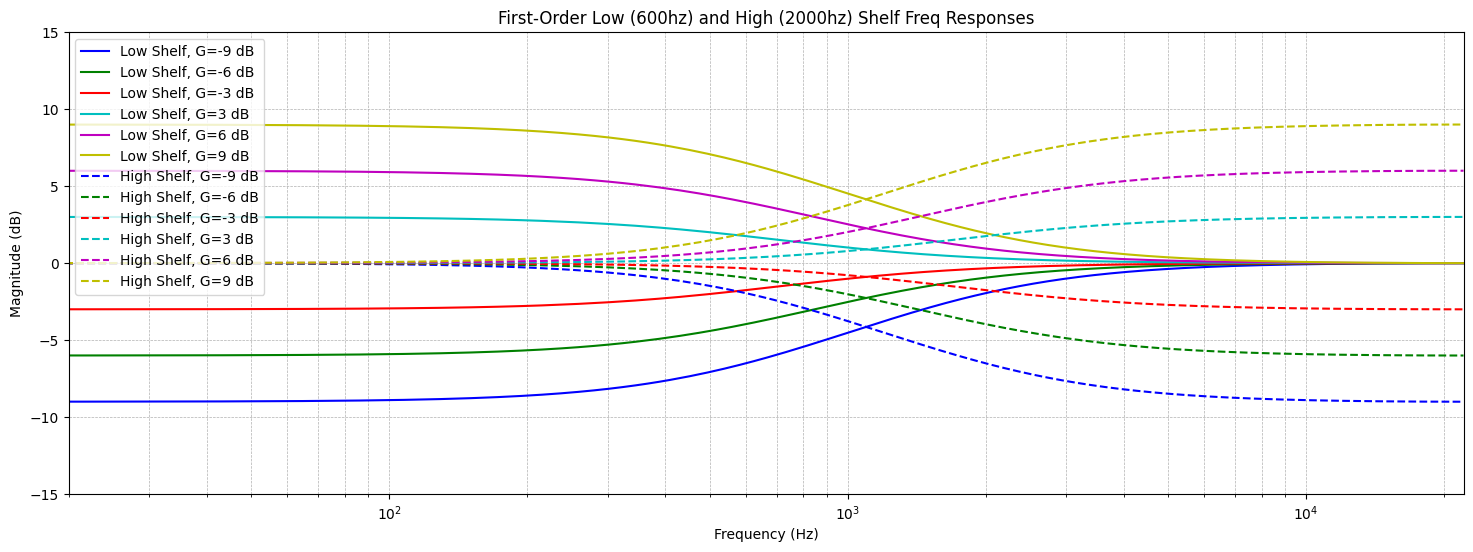

Original


First-Order Low Shelf @ gain=9, cutoff=600


First-Order High Shelf @ gain=9, cutoff=2000


In [109]:
def gain_param(G):
    V_0 = 10 ** (G / 20)
    
    return V_0 - 1, V_0

def shelf_params(V_0, fc, fs):
    tan = np.tan(np.pi * fc / fs)

    boost = (tan - 1)  / (tan + 1) 
    low_cut = (tan - V_0) / (tan + V_0)
    hi_cut = (V_0 * tan - 1) / (V_0 * tan + 1)


    return {
        "high": {
            "boost": boost,
            "cut": hi_cut,
        },
        "low": {
            "boost":  boost,
            "cut" : low_cut,
        }
    }

def shelf_filter(x, G, fc, fs, t='low'):
    N = len(x)
    x_h = np.zeros(N)
    y = np.zeros(N)

    gain_type = 'boost' if G >= 0 else 'cut'
    H_0, V_0 = gain_param(G)
    c = shelf_params(V_0, fc, fs)[t][gain_type]
    
    for n in range(N):
        if n == 0:
            x_h[n] = x[n]
            ap_y = c * x_h[n] + x_h[n]  
        else:
            x_h[n] = x[n] - c * x_h[n - 1]
            ap_y = c * x_h[n] + x_h[n - 1]
        
        if t == 'low':
            y[n] = 0.5 * H_0 * (x[n] + ap_y) + x[n]
        else:
            y[n] = 0.5 * H_0 * (x[n] - ap_y) + x[n]

    return y

def shelf_freq_response(G, fc, fs, t = 'low', n_points=1024):
    w = np.linspace(0, np.pi, n_points)
    H = np.zeros_like(w, dtype=complex)
    
    gain_type = 'boost' if G >= 0 else 'cut'
    H_0, V_0 = gain_param(G)
    c = shelf_params(V_0, fc, fs)[t][gain_type]

    for i, omega in enumerate(w):
        z = np.exp(1j * omega)
        A_z = (z ** -1 + c) / (1 + c * z ** -1)

        if t == 'low':
            H[i] = 1 + H_0 * 0.5 *(1 + A_z)
        else:
            H[i] = 1 + H_0 * 0.5 *(1 - A_z)

    freqs = (w * fs) / (np.pi * 2)

    # returning the db mags here for simplicity
    return freqs, 20 * np.log10(np.abs(H)) 

G = 10 # in DB
cutoffs=[600, 2000]
fs = sr # sample rate from opened file
gains = [-9, -6, -3, 3, 6, 9]  # Gains in dB
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Colors for different gain curves

low_shelved = shelf_filter(samples, G, cutoffs[0], fs, t = 'low')
high_shelved = shelf_filter(samples, G, cutoffs[1], fs, t = 'high')

plt.figure(figsize=(18, 6))  # Make the figure larger horizontally

for G, color in zip(gains, colors):
    freqs, H_low_db = shelf_freq_response(G, cutoffs[0], fs, t='low')
    plt.plot(freqs, H_low_db, linestyle='-', color=color, label=f"Low Shelf, G={G} dB")

for G, color in zip(gains, colors):
    freqs, H_high_db = shelf_freq_response(G, cutoffs[1], fs, t='high')
    plt.plot(freqs, H_high_db, linestyle='--', color=color, label=f"High Shelf, G={G} dB")


plt.xscale('log')
plt.xlim(20, fs / 2)  
plt.ylim(-15, 15)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title(f"First-Order Low ({cutoffs[0]}hz) and High ({cutoffs[1]}hz) Shelf Freq Responses")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

print("Original")
display(Audio(samples, rate=fs))
print(f"First-Order Low Shelf @ gain={G}, cutoff={cutoffs[0]}")
display(Audio(low_shelved, rate=fs))
print(f"First-Order High Shelf @ gain={G}, cutoff={cutoffs[1]}")
display(Audio(high_shelved, rate=fs))

## Second-Order

For the second-order design we need to introduce


| Filter     | $b_0$                                 | $b_1$                                   | $b_2$                                 | $a_1$                                | $a_2$                                  |
|------------|---------------------------------------|-----------------------------------------|---------------------------------------|--------------------------------------|----------------------------------------|
| Low Shelf Boost    | $\large\frac{1+\sqrt{2V_0}K + V_0K^2}{1 + \sqrt{2} K + K ^2}$ | $\large \frac{2(V_0K^2-1)}{1 + \sqrt{2}K +K^2}$ | $\large\frac{1 - \sqrt{2V_0}K + V_0K^2}{1 + \sqrt{2} K + K ^2}$ | $\large \frac{2(K^2 - 1)}{1 + \sqrt{2}K +K^2}$  | $\large\frac{1 - \sqrt{2}K + K^2}{1 + \sqrt{2} K + K ^2}$ |
| Low Shelf Cut    | $\large\frac{V_0(1+\sqrt{2}K + K^2)}{V_0 + \sqrt{2V_0} K + K ^2}$ | $\large \frac{2V_0(K^2-1)}{V_0 + \sqrt{2V_0} K + K ^2}$ | $\large\frac{V_0(1 - \sqrt{2}K + K^2)}{V_0 + \sqrt{2V_0} K + K ^2}$ | $\large \frac{2(K^2 - V_0)}{V_0 + \sqrt{2V_0} K + K ^2}$  | $\large\frac{V_0 - \sqrt{2V_0} K + K ^2}{V_0 + \sqrt{2V_0} K + K ^2}$ |
| High Shelf Boost    | $\large\frac{V_0+\sqrt{2V_0}K + K^2}{1 + \sqrt{2} K + K ^2}$ | $\large \frac{2(K^2 - V_0)}{1 + \sqrt{2}K +K^2}$ | $\large\frac{V_0 - \sqrt{2V_0}K + V_0K^2}{1 + \sqrt{2} K + K ^2}$ | $\large \frac{2(K^2 - 1)}{1 + \sqrt{2}K +K^2}$  | $\large\frac{1 - \sqrt{2}K + K^2}{1 + \sqrt{2} K + K ^2}$ |
